### 사이킷런 Wrapper XGBoost 개요 및 적용 
Boosting 이란?
- 여러 개의 약한 의사결정나무(Decision Tree)를 조합해서 사용하는 앙상블(Ensemble) 기법 중 하나
즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모형을 만든다.

XGBoost 란?
- XGBoost는 Extreme Gradient Boosting의 약자이다. 해석하면 극한 변화도(경사도) 부스팅
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적
- 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost 이다.
- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘 이다.

XGBoost의 장점
- GBM 대비 빠른 수행시간
- 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
- 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
- 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이하다.
- Missing Values : 결측치를 내부적으로 처리해준다. 실제로 kaggle에 적용해보는 과정에서 편리함

In [3]:
# p.232
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [8]:
print(dataset.target_names) # malignant : 악성종양, benign : 양성종양
cancer_df.target.value_counts()

['malignant' 'benign']


1    357
0    212
Name: target, dtype: int64

In [6]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [9]:
# p.233
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [10]:
# p.243
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
!pip install xgboost

In [25]:
# p.251
from xgboost import XGBClassifier
evals = [(X_test, y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=400, eval_set=evals,
                eval_metric='logloss', verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [15]:
get_clf_eval(y_test, w_preds, w_preds_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [17]:
# 210번에서 310번까지 반복동안 성능 평가 지수가 향상되지 않으므로 stop(early_stopping_rounds=100)
from xgboost import XGBClassifier
evals = [(X_test, y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals,
                eval_metric='logloss', verbose=True)
w100_preds = xgb_wrapper.predict(X_test)
w100_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]
# 100번째까지(early_stopping_rounds=100) 개선되는게 없으면 종료.
# 310종료됐다는것은 210에서부터 100번 시행동안 나아진게 없어서 종료

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [18]:
get_clf_eval(y_test, w100_preds, w100_preds_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

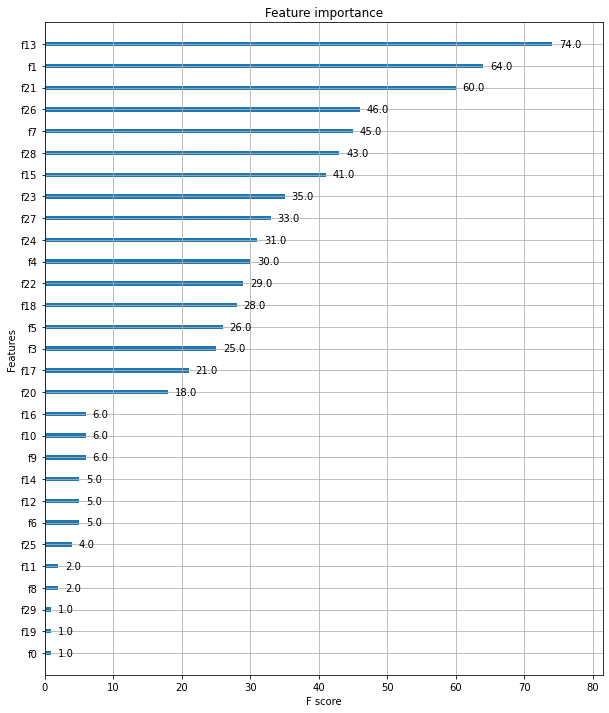

In [24]:
# p.253
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)

In [19]:
!pip install lightgbm

- 과제09/21 (3)<br> LightGBM을 이용하여 위스콘신 유방암 모델을 생성하고 평가 및 변수 중요도를 시각화하세요.

In [31]:
# p.250
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 80% 학습, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
# 위 train들 다시 쪼개서 90% 학습, 10% 검증용 데이터로 분류
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# n_estimators는 트리의 개수
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)
# LGBM도 XGBoost처럼 동일하게 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss",
                eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [32]:
# LightGBM모델 기반 예측 성능 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


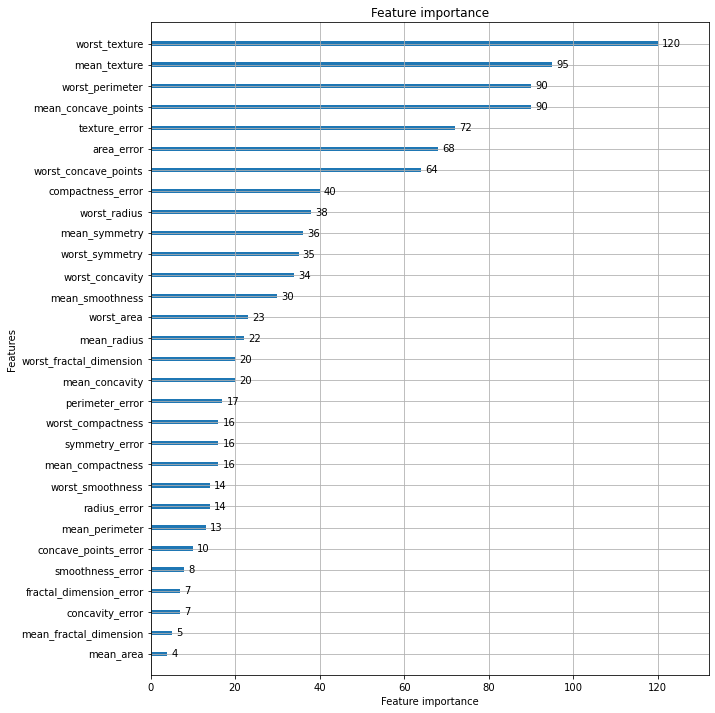

In [34]:
# plot_importance()를 이용하여 feature(변수) 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

[도전 과제] 캐글 산탄데르 고객 만족 예측을 수행하세요

https://www.kaggle.com/competitions/santander-customer-satisfaction/data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('./dataset/train_santander.csv', encoding='latin-1')
print(cust_df.shape)
cust_df.head() # 독립변수370개 + 레이블값(target)1개

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
cust_df.TARGET.value_counts()
unsatisfied_cnt = cust_df[cust_df.TARGET==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
unsatisfied_cnt/total_cnt

0.0395685345961589

In [5]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
cust_df.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [9]:
# vae3 피처 값 대체 및 ID 피처 드롭
cust_df.var3.replace(-999999,2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1] # X와 y값 분리
X_features.shape


(76020, 369)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(f'학습데이터:\n{y_train.value_counts()/train_cnt}')
print()
print(f'테스트데이터:\n{y_test.value_counts()/test_cnt}')

학습데이터:
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트데이터:
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [20]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
lgbm_clf = LGBMClassifier(n_estimators=500)
# LGBM의 조기 중단 수행 설정
evals = [(X_test, y_test)]
# 파라미터 직접 설정. verbose에 True를 주면 학습과정이 전부 출력됨
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=False)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC:{round(lgbm_roc_score, 4)}')

ROC AUC:0.8409


In [21]:
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200) # n_estimators는 트리의 개수

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train),(X_test, y_test)])
print(f'최적 파라미터: {gridcv.best_params_}')
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC:{round(lgbm_roc_score,4)}')

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	valid_1's binary_logloss: 0.146268
[9]	valid_0's auc: 0.850839	v

[1]	valid_0's auc: 0.825972	valid_0's binary_logloss: 0.15626	valid_1's auc: 0.817426	valid_1's binary_logloss: 0.165002
[2]	valid_0's auc: 0.830735	valid_0's binary_logloss: 0.150869	valid_1's auc: 0.821832	valid_1's binary_logloss: 0.159685
[3]	valid_0's auc: 0.836213	valid_0's binary_logloss: 0.147022	valid_1's auc: 0.825847	valid_1's binary_logloss: 0.156023
[4]	valid_0's auc: 0.839911	valid_0's binary_logloss: 0.143985	valid_1's auc: 0.830159	valid_1's binary_logloss: 0.153298
[5]	valid_0's auc: 0.842712	valid_0's binary_logloss: 0.14152	valid_1's auc: 0.831253	valid_1's binary_logloss: 0.151107
[6]	valid_0's auc: 0.84576	valid_0's binary_logloss: 0.139503	valid_1's auc: 0.835058	valid_1's binary_logloss: 0.149167
[7]	valid_0's auc: 0.84864	valid_0's binary_logloss: 0.137792	valid_1's auc: 0.836612	valid_1's binary_logloss: 0.147629
[8]	valid_0's auc: 0.850006	valid_0's binary_logloss: 0.136329	valid_1's auc: 0.837077	valid_1's binary_logloss: 0.146348
[9]	valid_0's auc: 0.852085	

[1]	valid_0's auc: 0.823422	valid_0's binary_logloss: 0.156446	valid_1's auc: 0.819043	valid_1's binary_logloss: 0.165337
[2]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.151103	valid_1's auc: 0.82466	valid_1's binary_logloss: 0.160151
[3]	valid_0's auc: 0.836251	valid_0's binary_logloss: 0.14724	valid_1's auc: 0.829717	valid_1's binary_logloss: 0.156452
[4]	valid_0's auc: 0.842516	valid_0's binary_logloss: 0.144162	valid_1's auc: 0.832695	valid_1's binary_logloss: 0.15358
[5]	valid_0's auc: 0.846316	valid_0's binary_logloss: 0.141636	valid_1's auc: 0.834705	valid_1's binary_logloss: 0.151246
[6]	valid_0's auc: 0.847998	valid_0's binary_logloss: 0.139517	valid_1's auc: 0.836546	valid_1's binary_logloss: 0.149374
[7]	valid_0's auc: 0.849074	valid_0's binary_logloss: 0.13782	valid_1's auc: 0.838333	valid_1's binary_logloss: 0.147794
[8]	valid_0's auc: 0.85	valid_0's binary_logloss: 0.136391	valid_1's auc: 0.838986	valid_1's binary_logloss: 0.146497
[9]	valid_0's auc: 0.851546	vali

[25]	valid_0's auc: 0.872827	valid_0's binary_logloss: 0.125201	valid_1's auc: 0.837438	valid_1's binary_logloss: 0.139775
[26]	valid_0's auc: 0.873522	valid_0's binary_logloss: 0.12487	valid_1's auc: 0.83729	valid_1's binary_logloss: 0.139751
[27]	valid_0's auc: 0.874428	valid_0's binary_logloss: 0.124521	valid_1's auc: 0.837295	valid_1's binary_logloss: 0.139667
[28]	valid_0's auc: 0.875453	valid_0's binary_logloss: 0.124204	valid_1's auc: 0.836916	valid_1's binary_logloss: 0.139693
[29]	valid_0's auc: 0.876968	valid_0's binary_logloss: 0.123851	valid_1's auc: 0.836543	valid_1's binary_logloss: 0.139692
[30]	valid_0's auc: 0.878211	valid_0's binary_logloss: 0.123513	valid_1's auc: 0.836768	valid_1's binary_logloss: 0.139653
[31]	valid_0's auc: 0.879123	valid_0's binary_logloss: 0.123238	valid_1's auc: 0.836337	valid_1's binary_logloss: 0.139687
[32]	valid_0's auc: 0.879609	valid_0's binary_logloss: 0.122982	valid_1's auc: 0.836481	valid_1's binary_logloss: 0.139632
[33]	valid_0's auc

[24]	valid_0's auc: 0.870532	valid_0's binary_logloss: 0.125527	valid_1's auc: 0.838429	valid_1's binary_logloss: 0.139818
[25]	valid_0's auc: 0.871628	valid_0's binary_logloss: 0.125118	valid_1's auc: 0.837908	valid_1's binary_logloss: 0.139768
[26]	valid_0's auc: 0.872816	valid_0's binary_logloss: 0.12478	valid_1's auc: 0.838203	valid_1's binary_logloss: 0.139683
[27]	valid_0's auc: 0.873647	valid_0's binary_logloss: 0.124448	valid_1's auc: 0.837808	valid_1's binary_logloss: 0.139669
[28]	valid_0's auc: 0.874326	valid_0's binary_logloss: 0.124117	valid_1's auc: 0.837756	valid_1's binary_logloss: 0.139635
[29]	valid_0's auc: 0.875069	valid_0's binary_logloss: 0.123826	valid_1's auc: 0.838037	valid_1's binary_logloss: 0.139565
[30]	valid_0's auc: 0.876092	valid_0's binary_logloss: 0.123541	valid_1's auc: 0.838013	valid_1's binary_logloss: 0.139571
[31]	valid_0's auc: 0.877253	valid_0's binary_logloss: 0.123222	valid_1's auc: 0.838176	valid_1's binary_logloss: 0.139525
[32]	valid_0's au

[23]	valid_0's auc: 0.872384	valid_0's binary_logloss: 0.125599	valid_1's auc: 0.840267	valid_1's binary_logloss: 0.14022
[24]	valid_0's auc: 0.873433	valid_0's binary_logloss: 0.125215	valid_1's auc: 0.840763	valid_1's binary_logloss: 0.140023
[25]	valid_0's auc: 0.874094	valid_0's binary_logloss: 0.124834	valid_1's auc: 0.840782	valid_1's binary_logloss: 0.139927
[26]	valid_0's auc: 0.875299	valid_0's binary_logloss: 0.12446	valid_1's auc: 0.840852	valid_1's binary_logloss: 0.139864
[27]	valid_0's auc: 0.875863	valid_0's binary_logloss: 0.124178	valid_1's auc: 0.840905	valid_1's binary_logloss: 0.139751
[28]	valid_0's auc: 0.876477	valid_0's binary_logloss: 0.123899	valid_1's auc: 0.840828	valid_1's binary_logloss: 0.139688
[29]	valid_0's auc: 0.877436	valid_0's binary_logloss: 0.123585	valid_1's auc: 0.840653	valid_1's binary_logloss: 0.139596
[30]	valid_0's auc: 0.878569	valid_0's binary_logloss: 0.123249	valid_1's auc: 0.841045	valid_1's binary_logloss: 0.139479
[31]	valid_0's auc

[34]	valid_0's auc: 0.900819	valid_0's binary_logloss: 0.115047	valid_1's auc: 0.836189	valid_1's binary_logloss: 0.139786
[35]	valid_0's auc: 0.901929	valid_0's binary_logloss: 0.114682	valid_1's auc: 0.836241	valid_1's binary_logloss: 0.139758
[36]	valid_0's auc: 0.902923	valid_0's binary_logloss: 0.114287	valid_1's auc: 0.836594	valid_1's binary_logloss: 0.139739
[37]	valid_0's auc: 0.903583	valid_0's binary_logloss: 0.113893	valid_1's auc: 0.836319	valid_1's binary_logloss: 0.139831
[38]	valid_0's auc: 0.904289	valid_0's binary_logloss: 0.113536	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139874
[39]	valid_0's auc: 0.904948	valid_0's binary_logloss: 0.113207	valid_1's auc: 0.835797	valid_1's binary_logloss: 0.139959
[40]	valid_0's auc: 0.905808	valid_0's binary_logloss: 0.112811	valid_1's auc: 0.835879	valid_1's binary_logloss: 0.139967
[41]	valid_0's auc: 0.906507	valid_0's binary_logloss: 0.112548	valid_1's auc: 0.835793	valid_1's binary_logloss: 0.139996
[42]	valid_0's a

[18]	valid_0's auc: 0.882607	valid_0's binary_logloss: 0.122935	valid_1's auc: 0.836156	valid_1's binary_logloss: 0.140354
[19]	valid_0's auc: 0.884204	valid_0's binary_logloss: 0.122205	valid_1's auc: 0.836909	valid_1's binary_logloss: 0.140094
[20]	valid_0's auc: 0.88564	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.139982
[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[36]	valid_0's auc: 0.902923	valid_0's binary_logloss: 0.114287	valid_1's auc: 0.836594	valid_1's binary_logloss: 0.139739
[37]	valid_0's auc: 0.903583	valid_0's binary_logloss: 0.113893	valid_1's auc: 0.836319	valid_1's binary_logloss: 0.139831
[38]	valid_0's auc: 0.904289	valid_0's binary_logloss: 0.113536	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139874
[39]	valid_0's auc: 0.904948	valid_0's binary_logloss: 0.113207	valid_1's auc: 0.835797	valid_1's binary_logloss: 0.139959
[40]	valid_0's auc: 0.905808	valid_0's binary_logloss: 0.112811	valid_1's auc: 0.835879	valid_1's binary_logloss: 0.139967
[41]	valid_0's auc: 0.906507	valid_0's binary_logloss: 0.112548	valid_1's auc: 0.835793	valid_1's binary_logloss: 0.139996
[42]	valid_0's auc: 0.907263	valid_0's binary_logloss: 0.112199	valid_1's auc: 0.835583	valid_1's binary_logloss: 0.140069
[43]	valid_0's auc: 0.907622	valid_0's binary_logloss: 0.111883	valid_1's auc: 0.835374	valid_1's binary_logloss: 0.140122
[44]	valid_0's a

[19]	valid_0's auc: 0.884204	valid_0's binary_logloss: 0.122205	valid_1's auc: 0.836909	valid_1's binary_logloss: 0.140094
[20]	valid_0's auc: 0.88564	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.139982
[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0.893944	valid_0's binary_logloss: 0.118169	valid_1's auc: 0.837371	valid_1's binary_logloss: 0.139458
[27]	valid_0's auc: 0

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[26]	valid_0's auc: 0.873412	valid_0's binary_logloss: 0.125313	valid_1's auc: 0.836946	valid_1's binary_logloss: 0.139742
[27]	valid_0's auc: 0.874137	valid_0's binary_logloss: 0.124988	valid_1's auc: 0.836586	valid_1's binary_logloss: 0.139799
[28]	valid_0's auc: 0.874911	valid_0's binary_logloss: 0.124675	valid_1's auc: 0.836489	valid_1's binary_logloss: 0.139742
[29]	valid_0's auc: 0.875538	valid_0's binary_logloss: 0.124397	valid_1's auc: 0.836554	valid_1's binary_logloss: 0.139712
[30]	valid_0's auc: 0.876317	valid_0's binary_logloss: 0.124137	valid_1's auc: 0.836181	valid_1's binary_logloss: 0.139716
[31]	valid_0's auc: 0.87724	valid_0's binary_logloss: 0.123841	valid_1's auc: 0.836284	valid_1's binary_logloss: 0.139683
[32]	valid_0's auc: 0.877783	valid_0's binary_logloss: 0.123594	valid_1's auc: 0.835851	valid_1's binary_logloss: 0.139729
[33]	valid_0's auc: 0.878348	valid_0's binary_logloss: 0.12338	valid_1's auc: 0.835408	valid_1's binary_logloss: 0.139824
[34]	valid_0's auc

[26]	valid_0's auc: 0.871934	valid_0's binary_logloss: 0.12537	valid_1's auc: 0.838594	valid_1's binary_logloss: 0.139669
[27]	valid_0's auc: 0.873048	valid_0's binary_logloss: 0.125049	valid_1's auc: 0.83847	valid_1's binary_logloss: 0.139655
[28]	valid_0's auc: 0.873824	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.838229	valid_1's binary_logloss: 0.139655
[29]	valid_0's auc: 0.874662	valid_0's binary_logloss: 0.124467	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139579
[30]	valid_0's auc: 0.87542	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.838156	valid_1's binary_logloss: 0.139548
[31]	valid_0's auc: 0.876207	valid_0's binary_logloss: 0.123915	valid_1's auc: 0.838237	valid_1's binary_logloss: 0.139538
[32]	valid_0's auc: 0.877156	valid_0's binary_logloss: 0.123623	valid_1's auc: 0.838271	valid_1's binary_logloss: 0.13947
[33]	valid_0's auc: 0.87768	valid_0's binary_logloss: 0.12338	valid_1's auc: 0.838713	valid_1's binary_logloss: 0.139346
[34]	valid_0's auc: 0.

[1]	valid_0's auc: 0.822477	valid_0's binary_logloss: 0.156615	valid_1's auc: 0.818936	valid_1's binary_logloss: 0.16507
[2]	valid_0's auc: 0.829931	valid_0's binary_logloss: 0.151227	valid_1's auc: 0.824213	valid_1's binary_logloss: 0.159973
[3]	valid_0's auc: 0.835788	valid_0's binary_logloss: 0.147372	valid_1's auc: 0.829555	valid_1's binary_logloss: 0.156407
[4]	valid_0's auc: 0.842398	valid_0's binary_logloss: 0.14436	valid_1's auc: 0.833204	valid_1's binary_logloss: 0.153426
[5]	valid_0's auc: 0.84472	valid_0's binary_logloss: 0.141969	valid_1's auc: 0.835438	valid_1's binary_logloss: 0.15118
[6]	valid_0's auc: 0.846873	valid_0's binary_logloss: 0.13984	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.149232
[7]	valid_0's auc: 0.849397	valid_0's binary_logloss: 0.138081	valid_1's auc: 0.838165	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.850636	valid_0's binary_logloss: 0.136651	valid_1's auc: 0.839203	valid_1's binary_logloss: 0.146397
[9]	valid_0's auc: 0.852058	v

[68]	valid_0's auc: 0.898008	valid_0's binary_logloss: 0.116079	valid_1's auc: 0.843355	valid_1's binary_logloss: 0.138452
[69]	valid_0's auc: 0.898293	valid_0's binary_logloss: 0.115943	valid_1's auc: 0.843203	valid_1's binary_logloss: 0.138515
[70]	valid_0's auc: 0.898585	valid_0's binary_logloss: 0.115794	valid_1's auc: 0.84311	valid_1's binary_logloss: 0.138551
[71]	valid_0's auc: 0.898878	valid_0's binary_logloss: 0.115634	valid_1's auc: 0.843163	valid_1's binary_logloss: 0.138557
[72]	valid_0's auc: 0.89933	valid_0's binary_logloss: 0.11544	valid_1's auc: 0.843123	valid_1's binary_logloss: 0.138587
[73]	valid_0's auc: 0.899665	valid_0's binary_logloss: 0.115279	valid_1's auc: 0.843158	valid_1's binary_logloss: 0.138606
[74]	valid_0's auc: 0.899872	valid_0's binary_logloss: 0.115145	valid_1's auc: 0.843153	valid_1's binary_logloss: 0.138622
[75]	valid_0's auc: 0.900318	valid_0's binary_logloss: 0.115012	valid_1's auc: 0.8431	valid_1's binary_logloss: 0.138652
[76]	valid_0's auc: 0

[25]	valid_0's auc: 0.870212	valid_0's binary_logloss: 0.125949	valid_1's auc: 0.837555	valid_1's binary_logloss: 0.14025
[26]	valid_0's auc: 0.871023	valid_0's binary_logloss: 0.125636	valid_1's auc: 0.837504	valid_1's binary_logloss: 0.140165
[27]	valid_0's auc: 0.872756	valid_0's binary_logloss: 0.125201	valid_1's auc: 0.837762	valid_1's binary_logloss: 0.140044
[28]	valid_0's auc: 0.874041	valid_0's binary_logloss: 0.124866	valid_1's auc: 0.837513	valid_1's binary_logloss: 0.14003
[29]	valid_0's auc: 0.875088	valid_0's binary_logloss: 0.12452	valid_1's auc: 0.837397	valid_1's binary_logloss: 0.140013
[30]	valid_0's auc: 0.876006	valid_0's binary_logloss: 0.124204	valid_1's auc: 0.837051	valid_1's binary_logloss: 0.140044
[31]	valid_0's auc: 0.876443	valid_0's binary_logloss: 0.123946	valid_1's auc: 0.837341	valid_1's binary_logloss: 0.139984
[32]	valid_0's auc: 0.877157	valid_0's binary_logloss: 0.123679	valid_1's auc: 0.837186	valid_1's binary_logloss: 0.139974
[33]	valid_0's auc:

[1]	valid_0's auc: 0.823467	valid_0's binary_logloss: 0.156234	valid_1's auc: 0.818359	valid_1's binary_logloss: 0.165045
[2]	valid_0's auc: 0.831432	valid_0's binary_logloss: 0.151096	valid_1's auc: 0.822806	valid_1's binary_logloss: 0.160035
[3]	valid_0's auc: 0.837942	valid_0's binary_logloss: 0.147265	valid_1's auc: 0.827733	valid_1's binary_logloss: 0.156278
[4]	valid_0's auc: 0.842228	valid_0's binary_logloss: 0.144266	valid_1's auc: 0.833199	valid_1's binary_logloss: 0.153439
[5]	valid_0's auc: 0.845913	valid_0's binary_logloss: 0.141908	valid_1's auc: 0.836078	valid_1's binary_logloss: 0.151112
[6]	valid_0's auc: 0.847301	valid_0's binary_logloss: 0.139924	valid_1's auc: 0.837962	valid_1's binary_logloss: 0.149212
[7]	valid_0's auc: 0.848494	valid_0's binary_logloss: 0.138267	valid_1's auc: 0.837664	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.849608	valid_0's binary_logloss: 0.136839	valid_1's auc: 0.839054	valid_1's binary_logloss: 0.146332
[9]	valid_0's auc: 0.851

[48]	valid_0's auc: 0.889206	valid_0's binary_logloss: 0.119781	valid_1's auc: 0.844708	valid_1's binary_logloss: 0.137947
[49]	valid_0's auc: 0.889545	valid_0's binary_logloss: 0.119601	valid_1's auc: 0.844447	valid_1's binary_logloss: 0.138002
[50]	valid_0's auc: 0.89018	valid_0's binary_logloss: 0.119358	valid_1's auc: 0.844336	valid_1's binary_logloss: 0.138021
[51]	valid_0's auc: 0.890603	valid_0's binary_logloss: 0.119182	valid_1's auc: 0.84438	valid_1's binary_logloss: 0.138019
[52]	valid_0's auc: 0.891517	valid_0's binary_logloss: 0.118924	valid_1's auc: 0.844393	valid_1's binary_logloss: 0.13803
[53]	valid_0's auc: 0.891938	valid_0's binary_logloss: 0.118749	valid_1's auc: 0.844183	valid_1's binary_logloss: 0.138086
[54]	valid_0's auc: 0.892252	valid_0's binary_logloss: 0.118601	valid_1's auc: 0.844352	valid_1's binary_logloss: 0.138077
[55]	valid_0's auc: 0.892749	valid_0's binary_logloss: 0.118391	valid_1's auc: 0.84432	valid_1's binary_logloss: 0.138057
[56]	valid_0's auc: 

[1]	valid_0's auc: 0.833297	valid_0's binary_logloss: 0.155798	valid_1's auc: 0.814648	valid_1's binary_logloss: 0.165178
[2]	valid_0's auc: 0.84496	valid_0's binary_logloss: 0.150106	valid_1's auc: 0.825101	valid_1's binary_logloss: 0.159672
[3]	valid_0's auc: 0.848339	valid_0's binary_logloss: 0.145999	valid_1's auc: 0.829756	valid_1's binary_logloss: 0.156122
[4]	valid_0's auc: 0.852327	valid_0's binary_logloss: 0.142785	valid_1's auc: 0.83262	valid_1's binary_logloss: 0.153215
[5]	valid_0's auc: 0.856991	valid_0's binary_logloss: 0.140075	valid_1's auc: 0.83528	valid_1's binary_logloss: 0.150936
[6]	valid_0's auc: 0.860123	valid_0's binary_logloss: 0.13786	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.149015
[7]	valid_0's auc: 0.862074	valid_0's binary_logloss: 0.135927	valid_1's auc: 0.837932	valid_1's binary_logloss: 0.147666
[8]	valid_0's auc: 0.863556	valid_0's binary_logloss: 0.134329	valid_1's auc: 0.837522	valid_1's binary_logloss: 0.146495
[9]	valid_0's auc: 0.865702	

[36]	valid_0's auc: 0.901261	valid_0's binary_logloss: 0.115448	valid_1's auc: 0.835902	valid_1's binary_logloss: 0.13999
[37]	valid_0's auc: 0.901964	valid_0's binary_logloss: 0.115083	valid_1's auc: 0.835674	valid_1's binary_logloss: 0.14012
[38]	valid_0's auc: 0.902511	valid_0's binary_logloss: 0.114769	valid_1's auc: 0.835307	valid_1's binary_logloss: 0.140207
[1]	valid_0's auc: 0.831709	valid_0's binary_logloss: 0.155602	valid_1's auc: 0.817142	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.845013	valid_0's binary_logloss: 0.15006	valid_1's auc: 0.83132	valid_1's binary_logloss: 0.159674
[3]	valid_0's auc: 0.847843	valid_0's binary_logloss: 0.145936	valid_1's auc: 0.833351	valid_1's binary_logloss: 0.155788
[4]	valid_0's auc: 0.853126	valid_0's binary_logloss: 0.142751	valid_1's auc: 0.836086	valid_1's binary_logloss: 0.152883
[5]	valid_0's auc: 0.855373	valid_0's binary_logloss: 0.140124	valid_1's auc: 0.836802	valid_1's binary_logloss: 0.150648
[6]	valid_0's auc: 0.8589

[17]	valid_0's auc: 0.879098	valid_0's binary_logloss: 0.125088	valid_1's auc: 0.837465	valid_1's binary_logloss: 0.1409
[18]	valid_0's auc: 0.880601	valid_0's binary_logloss: 0.124364	valid_1's auc: 0.837466	valid_1's binary_logloss: 0.140701
[19]	valid_0's auc: 0.88248	valid_0's binary_logloss: 0.123621	valid_1's auc: 0.838247	valid_1's binary_logloss: 0.140429
[20]	valid_0's auc: 0.883936	valid_0's binary_logloss: 0.122911	valid_1's auc: 0.83793	valid_1's binary_logloss: 0.140317
[21]	valid_0's auc: 0.88529	valid_0's binary_logloss: 0.122327	valid_1's auc: 0.838792	valid_1's binary_logloss: 0.140098
[22]	valid_0's auc: 0.88648	valid_0's binary_logloss: 0.121732	valid_1's auc: 0.838403	valid_1's binary_logloss: 0.139974
[23]	valid_0's auc: 0.887765	valid_0's binary_logloss: 0.121176	valid_1's auc: 0.838404	valid_1's binary_logloss: 0.139891
[24]	valid_0's auc: 0.888887	valid_0's binary_logloss: 0.120591	valid_1's auc: 0.838112	valid_1's binary_logloss: 0.139904
[25]	valid_0's auc: 0.

[19]	valid_0's auc: 0.881986	valid_0's binary_logloss: 0.123735	valid_1's auc: 0.834979	valid_1's binary_logloss: 0.140974
[20]	valid_0's auc: 0.883497	valid_0's binary_logloss: 0.123057	valid_1's auc: 0.834694	valid_1's binary_logloss: 0.140833
[21]	valid_0's auc: 0.88477	valid_0's binary_logloss: 0.122502	valid_1's auc: 0.83413	valid_1's binary_logloss: 0.140756
[22]	valid_0's auc: 0.886052	valid_0's binary_logloss: 0.121963	valid_1's auc: 0.833448	valid_1's binary_logloss: 0.140744
[23]	valid_0's auc: 0.88729	valid_0's binary_logloss: 0.121374	valid_1's auc: 0.832949	valid_1's binary_logloss: 0.140705
[24]	valid_0's auc: 0.888202	valid_0's binary_logloss: 0.120845	valid_1's auc: 0.832423	valid_1's binary_logloss: 0.140716
[25]	valid_0's auc: 0.889261	valid_0's binary_logloss: 0.120276	valid_1's auc: 0.832717	valid_1's binary_logloss: 0.140524
[26]	valid_0's auc: 0.89008	valid_0's binary_logloss: 0.119792	valid_1's auc: 0.832126	valid_1's binary_logloss: 0.140541
[27]	valid_0's auc: 

[18]	valid_0's auc: 0.879171	valid_0's binary_logloss: 0.124326	valid_1's auc: 0.837265	valid_1's binary_logloss: 0.140636
[19]	valid_0's auc: 0.880771	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.836922	valid_1's binary_logloss: 0.140454
[20]	valid_0's auc: 0.882476	valid_0's binary_logloss: 0.123001	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.140307
[21]	valid_0's auc: 0.883998	valid_0's binary_logloss: 0.122399	valid_1's auc: 0.83698	valid_1's binary_logloss: 0.140209
[22]	valid_0's auc: 0.885371	valid_0's binary_logloss: 0.121789	valid_1's auc: 0.836641	valid_1's binary_logloss: 0.140165
[23]	valid_0's auc: 0.886707	valid_0's binary_logloss: 0.121228	valid_1's auc: 0.836743	valid_1's binary_logloss: 0.140035
[24]	valid_0's auc: 0.887902	valid_0's binary_logloss: 0.120685	valid_1's auc: 0.83666	valid_1's binary_logloss: 0.139977
[25]	valid_0's auc: 0.889092	valid_0's binary_logloss: 0.12018	valid_1's auc: 0.83633	valid_1's binary_logloss: 0.139976
[26]	valid_0's auc: 

[49]	valid_0's auc: 0.90574	valid_0's binary_logloss: 0.112462	valid_1's auc: 0.835874	valid_1's binary_logloss: 0.140337
[50]	valid_0's auc: 0.906329	valid_0's binary_logloss: 0.112158	valid_1's auc: 0.835754	valid_1's binary_logloss: 0.140395
[51]	valid_0's auc: 0.906807	valid_0's binary_logloss: 0.111885	valid_1's auc: 0.835957	valid_1's binary_logloss: 0.140381
[52]	valid_0's auc: 0.907054	valid_0's binary_logloss: 0.111647	valid_1's auc: 0.835498	valid_1's binary_logloss: 0.14054
[1]	valid_0's auc: 0.832354	valid_0's binary_logloss: 0.156011	valid_1's auc: 0.824432	valid_1's binary_logloss: 0.164746
[2]	valid_0's auc: 0.845573	valid_0's binary_logloss: 0.150188	valid_1's auc: 0.832252	valid_1's binary_logloss: 0.159476
[3]	valid_0's auc: 0.848609	valid_0's binary_logloss: 0.145958	valid_1's auc: 0.834138	valid_1's binary_logloss: 0.155738
[4]	valid_0's auc: 0.851924	valid_0's binary_logloss: 0.142678	valid_1's auc: 0.834388	valid_1's binary_logloss: 0.152853
[5]	valid_0's auc: 0.8

[67]	valid_0's auc: 0.918245	valid_0's binary_logloss: 0.106235	valid_1's auc: 0.835775	valid_1's binary_logloss: 0.140673
[68]	valid_0's auc: 0.918757	valid_0's binary_logloss: 0.105956	valid_1's auc: 0.8357	valid_1's binary_logloss: 0.140696
[69]	valid_0's auc: 0.919319	valid_0's binary_logloss: 0.105704	valid_1's auc: 0.83538	valid_1's binary_logloss: 0.140788
[70]	valid_0's auc: 0.919498	valid_0's binary_logloss: 0.105505	valid_1's auc: 0.834956	valid_1's binary_logloss: 0.140912
[71]	valid_0's auc: 0.919774	valid_0's binary_logloss: 0.105296	valid_1's auc: 0.834571	valid_1's binary_logloss: 0.141016
[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.839

[26]	valid_0's auc: 0.872886	valid_0's binary_logloss: 0.125108	valid_1's auc: 0.836911	valid_1's binary_logloss: 0.140274
[27]	valid_0's auc: 0.873971	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.140247
[28]	valid_0's auc: 0.875129	valid_0's binary_logloss: 0.124434	valid_1's auc: 0.837012	valid_1's binary_logloss: 0.140143
[29]	valid_0's auc: 0.875873	valid_0's binary_logloss: 0.12414	valid_1's auc: 0.836866	valid_1's binary_logloss: 0.140163
[30]	valid_0's auc: 0.876465	valid_0's binary_logloss: 0.123865	valid_1's auc: 0.836337	valid_1's binary_logloss: 0.140195
[31]	valid_0's auc: 0.877699	valid_0's binary_logloss: 0.123521	valid_1's auc: 0.836229	valid_1's binary_logloss: 0.140186
[32]	valid_0's auc: 0.878492	valid_0's binary_logloss: 0.123253	valid_1's auc: 0.836388	valid_1's binary_logloss: 0.140145
[33]	valid_0's auc: 0.879281	valid_0's binary_logloss: 0.122981	valid_1's auc: 0.836061	valid_1's binary_logloss: 0.140165
[34]	valid_0's au

[27]	valid_0's auc: 0.873565	valid_0's binary_logloss: 0.124623	valid_1's auc: 0.838679	valid_1's binary_logloss: 0.139786
[28]	valid_0's auc: 0.874397	valid_0's binary_logloss: 0.124307	valid_1's auc: 0.83805	valid_1's binary_logloss: 0.139815
[29]	valid_0's auc: 0.87544	valid_0's binary_logloss: 0.124018	valid_1's auc: 0.837719	valid_1's binary_logloss: 0.139819
[30]	valid_0's auc: 0.876222	valid_0's binary_logloss: 0.123733	valid_1's auc: 0.838003	valid_1's binary_logloss: 0.139778
[31]	valid_0's auc: 0.877142	valid_0's binary_logloss: 0.12348	valid_1's auc: 0.838078	valid_1's binary_logloss: 0.139735
[32]	valid_0's auc: 0.877956	valid_0's binary_logloss: 0.123203	valid_1's auc: 0.838002	valid_1's binary_logloss: 0.139729
[33]	valid_0's auc: 0.878477	valid_0's binary_logloss: 0.122964	valid_1's auc: 0.838203	valid_1's binary_logloss: 0.139665
[34]	valid_0's auc: 0.879048	valid_0's binary_logloss: 0.122668	valid_1's auc: 0.838296	valid_1's binary_logloss: 0.139589
[35]	valid_0's auc:

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	valid_1's binary_logloss: 0.146268
[9]	valid_0's auc: 0.850839	v

[1]	valid_0's auc: 0.825972	valid_0's binary_logloss: 0.15626	valid_1's auc: 0.817426	valid_1's binary_logloss: 0.165002
[2]	valid_0's auc: 0.830735	valid_0's binary_logloss: 0.150869	valid_1's auc: 0.821832	valid_1's binary_logloss: 0.159685
[3]	valid_0's auc: 0.836213	valid_0's binary_logloss: 0.147022	valid_1's auc: 0.825847	valid_1's binary_logloss: 0.156023
[4]	valid_0's auc: 0.839911	valid_0's binary_logloss: 0.143985	valid_1's auc: 0.830159	valid_1's binary_logloss: 0.153298
[5]	valid_0's auc: 0.842712	valid_0's binary_logloss: 0.14152	valid_1's auc: 0.831253	valid_1's binary_logloss: 0.151107
[6]	valid_0's auc: 0.84576	valid_0's binary_logloss: 0.139503	valid_1's auc: 0.835058	valid_1's binary_logloss: 0.149167
[7]	valid_0's auc: 0.84864	valid_0's binary_logloss: 0.137792	valid_1's auc: 0.836612	valid_1's binary_logloss: 0.147629
[8]	valid_0's auc: 0.850006	valid_0's binary_logloss: 0.136329	valid_1's auc: 0.837077	valid_1's binary_logloss: 0.146348
[9]	valid_0's auc: 0.852085	

[1]	valid_0's auc: 0.823422	valid_0's binary_logloss: 0.156446	valid_1's auc: 0.819043	valid_1's binary_logloss: 0.165337
[2]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.151103	valid_1's auc: 0.82466	valid_1's binary_logloss: 0.160151
[3]	valid_0's auc: 0.836251	valid_0's binary_logloss: 0.14724	valid_1's auc: 0.829717	valid_1's binary_logloss: 0.156452
[4]	valid_0's auc: 0.842516	valid_0's binary_logloss: 0.144162	valid_1's auc: 0.832695	valid_1's binary_logloss: 0.15358
[5]	valid_0's auc: 0.846316	valid_0's binary_logloss: 0.141636	valid_1's auc: 0.834705	valid_1's binary_logloss: 0.151246
[6]	valid_0's auc: 0.847998	valid_0's binary_logloss: 0.139517	valid_1's auc: 0.836546	valid_1's binary_logloss: 0.149374
[7]	valid_0's auc: 0.849074	valid_0's binary_logloss: 0.13782	valid_1's auc: 0.838333	valid_1's binary_logloss: 0.147794
[8]	valid_0's auc: 0.85	valid_0's binary_logloss: 0.136391	valid_1's auc: 0.838986	valid_1's binary_logloss: 0.146497
[9]	valid_0's auc: 0.851546	vali

[19]	valid_0's auc: 0.884069	valid_0's binary_logloss: 0.1225	valid_1's auc: 0.836798	valid_1's binary_logloss: 0.140747
[20]	valid_0's auc: 0.885553	valid_0's binary_logloss: 0.121835	valid_1's auc: 0.837335	valid_1's binary_logloss: 0.140578
[21]	valid_0's auc: 0.886758	valid_0's binary_logloss: 0.121199	valid_1's auc: 0.837053	valid_1's binary_logloss: 0.1405
[22]	valid_0's auc: 0.888245	valid_0's binary_logloss: 0.120566	valid_1's auc: 0.837133	valid_1's binary_logloss: 0.140423
[23]	valid_0's auc: 0.889287	valid_0's binary_logloss: 0.119999	valid_1's auc: 0.837039	valid_1's binary_logloss: 0.140319
[24]	valid_0's auc: 0.890242	valid_0's binary_logloss: 0.119535	valid_1's auc: 0.837226	valid_1's binary_logloss: 0.140192
[25]	valid_0's auc: 0.89128	valid_0's binary_logloss: 0.119025	valid_1's auc: 0.836975	valid_1's binary_logloss: 0.140152
[26]	valid_0's auc: 0.892936	valid_0's binary_logloss: 0.118515	valid_1's auc: 0.836466	valid_1's binary_logloss: 0.14011
[27]	valid_0's auc: 0.

[19]	valid_0's auc: 0.884204	valid_0's binary_logloss: 0.122205	valid_1's auc: 0.836909	valid_1's binary_logloss: 0.140094
[20]	valid_0's auc: 0.88564	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.139982
[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0.893944	valid_0's binary_logloss: 0.118169	valid_1's auc: 0.837371	valid_1's binary_logloss: 0.139458
[27]	valid_0's auc: 0

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[34]	valid_0's auc: 0.900819	valid_0's binary_logloss: 0.115047	valid_1's auc: 0.836189	valid_1's binary_logloss: 0.139786
[35]	valid_0's auc: 0.901929	valid_0's binary_logloss: 0.114682	valid_1's auc: 0.836241	valid_1's binary_logloss: 0.139758
[36]	valid_0's auc: 0.902923	valid_0's binary_logloss: 0.114287	valid_1's auc: 0.836594	valid_1's binary_logloss: 0.139739
[37]	valid_0's auc: 0.903583	valid_0's binary_logloss: 0.113893	valid_1's auc: 0.836319	valid_1's binary_logloss: 0.139831
[38]	valid_0's auc: 0.904289	valid_0's binary_logloss: 0.113536	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139874
[39]	valid_0's auc: 0.904948	valid_0's binary_logloss: 0.113207	valid_1's auc: 0.835797	valid_1's binary_logloss: 0.139959
[40]	valid_0's auc: 0.905808	valid_0's binary_logloss: 0.112811	valid_1's auc: 0.835879	valid_1's binary_logloss: 0.139967
[41]	valid_0's auc: 0.906507	valid_0's binary_logloss: 0.112548	valid_1's auc: 0.835793	valid_1's binary_logloss: 0.139996
[42]	valid_0's a

[18]	valid_0's auc: 0.882607	valid_0's binary_logloss: 0.122935	valid_1's auc: 0.836156	valid_1's binary_logloss: 0.140354
[19]	valid_0's auc: 0.884204	valid_0's binary_logloss: 0.122205	valid_1's auc: 0.836909	valid_1's binary_logloss: 0.140094
[20]	valid_0's auc: 0.88564	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.139982
[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[24]	valid_0's auc: 0.871205	valid_0's binary_logloss: 0.12605	valid_1's auc: 0.837453	valid_1's binary_logloss: 0.139824
[25]	valid_0's auc: 0.871806	valid_0's binary_logloss: 0.125728	valid_1's auc: 0.837283	valid_1's binary_logloss: 0.13976
[26]	valid_0's auc: 0.873412	valid_0's binary_logloss: 0.125313	valid_1's auc: 0.836946	valid_1's binary_logloss: 0.139742
[27]	valid_0's auc: 0.874137	valid_0's binary_logloss: 0.124988	valid_1's auc: 0.836586	valid_1's binary_logloss: 0.139799
[28]	valid_0's auc: 0.874911	valid_0's binary_logloss: 0.124675	valid_1's auc: 0.836489	valid_1's binary_logloss: 0.139742
[29]	valid_0's auc: 0.875538	valid_0's binary_logloss: 0.124397	valid_1's auc: 0.836554	valid_1's binary_logloss: 0.139712
[30]	valid_0's auc: 0.876317	valid_0's binary_logloss: 0.124137	valid_1's auc: 0.836181	valid_1's binary_logloss: 0.139716
[31]	valid_0's auc: 0.87724	valid_0's binary_logloss: 0.123841	valid_1's auc: 0.836284	valid_1's binary_logloss: 0.139683
[32]	valid_0's auc:

[26]	valid_0's auc: 0.871934	valid_0's binary_logloss: 0.12537	valid_1's auc: 0.838594	valid_1's binary_logloss: 0.139669
[27]	valid_0's auc: 0.873048	valid_0's binary_logloss: 0.125049	valid_1's auc: 0.83847	valid_1's binary_logloss: 0.139655
[28]	valid_0's auc: 0.873824	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.838229	valid_1's binary_logloss: 0.139655
[29]	valid_0's auc: 0.874662	valid_0's binary_logloss: 0.124467	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139579
[30]	valid_0's auc: 0.87542	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.838156	valid_1's binary_logloss: 0.139548
[31]	valid_0's auc: 0.876207	valid_0's binary_logloss: 0.123915	valid_1's auc: 0.838237	valid_1's binary_logloss: 0.139538
[32]	valid_0's auc: 0.877156	valid_0's binary_logloss: 0.123623	valid_1's auc: 0.838271	valid_1's binary_logloss: 0.13947
[33]	valid_0's auc: 0.87768	valid_0's binary_logloss: 0.12338	valid_1's auc: 0.838713	valid_1's binary_logloss: 0.139346
[34]	valid_0's auc: 0.

[1]	valid_0's auc: 0.822477	valid_0's binary_logloss: 0.156615	valid_1's auc: 0.818936	valid_1's binary_logloss: 0.16507
[2]	valid_0's auc: 0.829931	valid_0's binary_logloss: 0.151227	valid_1's auc: 0.824213	valid_1's binary_logloss: 0.159973
[3]	valid_0's auc: 0.835788	valid_0's binary_logloss: 0.147372	valid_1's auc: 0.829555	valid_1's binary_logloss: 0.156407
[4]	valid_0's auc: 0.842398	valid_0's binary_logloss: 0.14436	valid_1's auc: 0.833204	valid_1's binary_logloss: 0.153426
[5]	valid_0's auc: 0.84472	valid_0's binary_logloss: 0.141969	valid_1's auc: 0.835438	valid_1's binary_logloss: 0.15118
[6]	valid_0's auc: 0.846873	valid_0's binary_logloss: 0.13984	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.149232
[7]	valid_0's auc: 0.849397	valid_0's binary_logloss: 0.138081	valid_1's auc: 0.838165	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.850636	valid_0's binary_logloss: 0.136651	valid_1's auc: 0.839203	valid_1's binary_logloss: 0.146397
[9]	valid_0's auc: 0.852058	v

[68]	valid_0's auc: 0.898008	valid_0's binary_logloss: 0.116079	valid_1's auc: 0.843355	valid_1's binary_logloss: 0.138452
[69]	valid_0's auc: 0.898293	valid_0's binary_logloss: 0.115943	valid_1's auc: 0.843203	valid_1's binary_logloss: 0.138515
[70]	valid_0's auc: 0.898585	valid_0's binary_logloss: 0.115794	valid_1's auc: 0.84311	valid_1's binary_logloss: 0.138551
[71]	valid_0's auc: 0.898878	valid_0's binary_logloss: 0.115634	valid_1's auc: 0.843163	valid_1's binary_logloss: 0.138557
[72]	valid_0's auc: 0.89933	valid_0's binary_logloss: 0.11544	valid_1's auc: 0.843123	valid_1's binary_logloss: 0.138587
[73]	valid_0's auc: 0.899665	valid_0's binary_logloss: 0.115279	valid_1's auc: 0.843158	valid_1's binary_logloss: 0.138606
[74]	valid_0's auc: 0.899872	valid_0's binary_logloss: 0.115145	valid_1's auc: 0.843153	valid_1's binary_logloss: 0.138622
[75]	valid_0's auc: 0.900318	valid_0's binary_logloss: 0.115012	valid_1's auc: 0.8431	valid_1's binary_logloss: 0.138652
[76]	valid_0's auc: 0

[22]	valid_0's auc: 0.867435	valid_0's binary_logloss: 0.12708	valid_1's auc: 0.837639	valid_1's binary_logloss: 0.1406
[23]	valid_0's auc: 0.868304	valid_0's binary_logloss: 0.12669	valid_1's auc: 0.837619	valid_1's binary_logloss: 0.140434
[24]	valid_0's auc: 0.869271	valid_0's binary_logloss: 0.126307	valid_1's auc: 0.838019	valid_1's binary_logloss: 0.140281
[25]	valid_0's auc: 0.870212	valid_0's binary_logloss: 0.125949	valid_1's auc: 0.837555	valid_1's binary_logloss: 0.14025
[26]	valid_0's auc: 0.871023	valid_0's binary_logloss: 0.125636	valid_1's auc: 0.837504	valid_1's binary_logloss: 0.140165
[27]	valid_0's auc: 0.872756	valid_0's binary_logloss: 0.125201	valid_1's auc: 0.837762	valid_1's binary_logloss: 0.140044
[28]	valid_0's auc: 0.874041	valid_0's binary_logloss: 0.124866	valid_1's auc: 0.837513	valid_1's binary_logloss: 0.14003
[29]	valid_0's auc: 0.875088	valid_0's binary_logloss: 0.12452	valid_1's auc: 0.837397	valid_1's binary_logloss: 0.140013
[30]	valid_0's auc: 0.8

[1]	valid_0's auc: 0.823467	valid_0's binary_logloss: 0.156234	valid_1's auc: 0.818359	valid_1's binary_logloss: 0.165045
[2]	valid_0's auc: 0.831432	valid_0's binary_logloss: 0.151096	valid_1's auc: 0.822806	valid_1's binary_logloss: 0.160035
[3]	valid_0's auc: 0.837942	valid_0's binary_logloss: 0.147265	valid_1's auc: 0.827733	valid_1's binary_logloss: 0.156278
[4]	valid_0's auc: 0.842228	valid_0's binary_logloss: 0.144266	valid_1's auc: 0.833199	valid_1's binary_logloss: 0.153439
[5]	valid_0's auc: 0.845913	valid_0's binary_logloss: 0.141908	valid_1's auc: 0.836078	valid_1's binary_logloss: 0.151112
[6]	valid_0's auc: 0.847301	valid_0's binary_logloss: 0.139924	valid_1's auc: 0.837962	valid_1's binary_logloss: 0.149212
[7]	valid_0's auc: 0.848494	valid_0's binary_logloss: 0.138267	valid_1's auc: 0.837664	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.849608	valid_0's binary_logloss: 0.136839	valid_1's auc: 0.839054	valid_1's binary_logloss: 0.146332
[9]	valid_0's auc: 0.851

[44]	valid_0's auc: 0.887071	valid_0's binary_logloss: 0.120678	valid_1's auc: 0.844103	valid_1's binary_logloss: 0.138065
[45]	valid_0's auc: 0.887784	valid_0's binary_logloss: 0.120428	valid_1's auc: 0.844152	valid_1's binary_logloss: 0.138057
[46]	valid_0's auc: 0.888342	valid_0's binary_logloss: 0.120223	valid_1's auc: 0.844297	valid_1's binary_logloss: 0.138025
[47]	valid_0's auc: 0.888722	valid_0's binary_logloss: 0.119986	valid_1's auc: 0.844276	valid_1's binary_logloss: 0.138002
[48]	valid_0's auc: 0.889206	valid_0's binary_logloss: 0.119781	valid_1's auc: 0.844708	valid_1's binary_logloss: 0.137947
[49]	valid_0's auc: 0.889545	valid_0's binary_logloss: 0.119601	valid_1's auc: 0.844447	valid_1's binary_logloss: 0.138002
[50]	valid_0's auc: 0.89018	valid_0's binary_logloss: 0.119358	valid_1's auc: 0.844336	valid_1's binary_logloss: 0.138021
[51]	valid_0's auc: 0.890603	valid_0's binary_logloss: 0.119182	valid_1's auc: 0.84438	valid_1's binary_logloss: 0.138019
[52]	valid_0's auc

[35]	valid_0's auc: 0.899431	valid_0's binary_logloss: 0.115966	valid_1's auc: 0.832323	valid_1's binary_logloss: 0.140357
[36]	valid_0's auc: 0.900259	valid_0's binary_logloss: 0.115619	valid_1's auc: 0.832052	valid_1's binary_logloss: 0.140411
[37]	valid_0's auc: 0.901414	valid_0's binary_logloss: 0.115269	valid_1's auc: 0.832144	valid_1's binary_logloss: 0.14042
[38]	valid_0's auc: 0.902365	valid_0's binary_logloss: 0.114862	valid_1's auc: 0.832015	valid_1's binary_logloss: 0.140464
[39]	valid_0's auc: 0.90309	valid_0's binary_logloss: 0.114499	valid_1's auc: 0.832257	valid_1's binary_logloss: 0.140399
[1]	valid_0's auc: 0.833297	valid_0's binary_logloss: 0.155798	valid_1's auc: 0.814648	valid_1's binary_logloss: 0.165178
[2]	valid_0's auc: 0.84496	valid_0's binary_logloss: 0.150106	valid_1's auc: 0.825101	valid_1's binary_logloss: 0.159672
[3]	valid_0's auc: 0.848339	valid_0's binary_logloss: 0.145999	valid_1's auc: 0.829756	valid_1's binary_logloss: 0.156122
[4]	valid_0's auc: 0.8

[31]	valid_0's auc: 0.895735	valid_0's binary_logloss: 0.117395	valid_1's auc: 0.835985	valid_1's binary_logloss: 0.139865
[32]	valid_0's auc: 0.896982	valid_0's binary_logloss: 0.116948	valid_1's auc: 0.836178	valid_1's binary_logloss: 0.139866
[33]	valid_0's auc: 0.898332	valid_0's binary_logloss: 0.116584	valid_1's auc: 0.836498	valid_1's binary_logloss: 0.139828
[34]	valid_0's auc: 0.899324	valid_0's binary_logloss: 0.116129	valid_1's auc: 0.836499	valid_1's binary_logloss: 0.139874
[35]	valid_0's auc: 0.900175	valid_0's binary_logloss: 0.11578	valid_1's auc: 0.836226	valid_1's binary_logloss: 0.139924
[36]	valid_0's auc: 0.901261	valid_0's binary_logloss: 0.115448	valid_1's auc: 0.835902	valid_1's binary_logloss: 0.13999
[37]	valid_0's auc: 0.901964	valid_0's binary_logloss: 0.115083	valid_1's auc: 0.835674	valid_1's binary_logloss: 0.14012
[38]	valid_0's auc: 0.902511	valid_0's binary_logloss: 0.114769	valid_1's auc: 0.835307	valid_1's binary_logloss: 0.140207
[1]	valid_0's auc: 

[18]	valid_0's auc: 0.880601	valid_0's binary_logloss: 0.124364	valid_1's auc: 0.837466	valid_1's binary_logloss: 0.140701
[19]	valid_0's auc: 0.88248	valid_0's binary_logloss: 0.123621	valid_1's auc: 0.838247	valid_1's binary_logloss: 0.140429
[20]	valid_0's auc: 0.883936	valid_0's binary_logloss: 0.122911	valid_1's auc: 0.83793	valid_1's binary_logloss: 0.140317
[21]	valid_0's auc: 0.88529	valid_0's binary_logloss: 0.122327	valid_1's auc: 0.838792	valid_1's binary_logloss: 0.140098
[22]	valid_0's auc: 0.88648	valid_0's binary_logloss: 0.121732	valid_1's auc: 0.838403	valid_1's binary_logloss: 0.139974
[23]	valid_0's auc: 0.887765	valid_0's binary_logloss: 0.121176	valid_1's auc: 0.838404	valid_1's binary_logloss: 0.139891
[24]	valid_0's auc: 0.888887	valid_0's binary_logloss: 0.120591	valid_1's auc: 0.838112	valid_1's binary_logloss: 0.139904
[25]	valid_0's auc: 0.890044	valid_0's binary_logloss: 0.120074	valid_1's auc: 0.838114	valid_1's binary_logloss: 0.139883
[26]	valid_0's auc: 

[18]	valid_0's auc: 0.880333	valid_0's binary_logloss: 0.12445	valid_1's auc: 0.835408	valid_1's binary_logloss: 0.14109
[19]	valid_0's auc: 0.881986	valid_0's binary_logloss: 0.123735	valid_1's auc: 0.834979	valid_1's binary_logloss: 0.140974
[20]	valid_0's auc: 0.883497	valid_0's binary_logloss: 0.123057	valid_1's auc: 0.834694	valid_1's binary_logloss: 0.140833
[21]	valid_0's auc: 0.88477	valid_0's binary_logloss: 0.122502	valid_1's auc: 0.83413	valid_1's binary_logloss: 0.140756
[22]	valid_0's auc: 0.886052	valid_0's binary_logloss: 0.121963	valid_1's auc: 0.833448	valid_1's binary_logloss: 0.140744
[23]	valid_0's auc: 0.88729	valid_0's binary_logloss: 0.121374	valid_1's auc: 0.832949	valid_1's binary_logloss: 0.140705
[24]	valid_0's auc: 0.888202	valid_0's binary_logloss: 0.120845	valid_1's auc: 0.832423	valid_1's binary_logloss: 0.140716
[25]	valid_0's auc: 0.889261	valid_0's binary_logloss: 0.120276	valid_1's auc: 0.832717	valid_1's binary_logloss: 0.140524
[26]	valid_0's auc: 0

[18]	valid_0's auc: 0.879171	valid_0's binary_logloss: 0.124326	valid_1's auc: 0.837265	valid_1's binary_logloss: 0.140636
[19]	valid_0's auc: 0.880771	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.836922	valid_1's binary_logloss: 0.140454
[20]	valid_0's auc: 0.882476	valid_0's binary_logloss: 0.123001	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.140307
[21]	valid_0's auc: 0.883998	valid_0's binary_logloss: 0.122399	valid_1's auc: 0.83698	valid_1's binary_logloss: 0.140209
[22]	valid_0's auc: 0.885371	valid_0's binary_logloss: 0.121789	valid_1's auc: 0.836641	valid_1's binary_logloss: 0.140165
[23]	valid_0's auc: 0.886707	valid_0's binary_logloss: 0.121228	valid_1's auc: 0.836743	valid_1's binary_logloss: 0.140035
[24]	valid_0's auc: 0.887902	valid_0's binary_logloss: 0.120685	valid_1's auc: 0.83666	valid_1's binary_logloss: 0.139977
[25]	valid_0's auc: 0.889092	valid_0's binary_logloss: 0.12018	valid_1's auc: 0.83633	valid_1's binary_logloss: 0.139976
[26]	valid_0's auc: 

[50]	valid_0's auc: 0.906329	valid_0's binary_logloss: 0.112158	valid_1's auc: 0.835754	valid_1's binary_logloss: 0.140395
[51]	valid_0's auc: 0.906807	valid_0's binary_logloss: 0.111885	valid_1's auc: 0.835957	valid_1's binary_logloss: 0.140381
[52]	valid_0's auc: 0.907054	valid_0's binary_logloss: 0.111647	valid_1's auc: 0.835498	valid_1's binary_logloss: 0.14054
[1]	valid_0's auc: 0.832354	valid_0's binary_logloss: 0.156011	valid_1's auc: 0.824432	valid_1's binary_logloss: 0.164746
[2]	valid_0's auc: 0.845573	valid_0's binary_logloss: 0.150188	valid_1's auc: 0.832252	valid_1's binary_logloss: 0.159476
[3]	valid_0's auc: 0.848609	valid_0's binary_logloss: 0.145958	valid_1's auc: 0.834138	valid_1's binary_logloss: 0.155738
[4]	valid_0's auc: 0.851924	valid_0's binary_logloss: 0.142678	valid_1's auc: 0.834388	valid_1's binary_logloss: 0.152853
[5]	valid_0's auc: 0.854459	valid_0's binary_logloss: 0.140096	valid_1's auc: 0.834654	valid_1's binary_logloss: 0.150614
[6]	valid_0's auc: 0.8

[1]	training's auc: 0.823615	training's binary_logloss: 0.15611	valid_1's auc: 0.816534	valid_1's binary_logloss: 0.165167
[2]	training's auc: 0.828024	training's binary_logloss: 0.150857	valid_1's auc: 0.81932	valid_1's binary_logloss: 0.160019
[3]	training's auc: 0.837813	training's binary_logloss: 0.146978	valid_1's auc: 0.827935	valid_1's binary_logloss: 0.156362
[4]	training's auc: 0.843266	training's binary_logloss: 0.143948	valid_1's auc: 0.833269	valid_1's binary_logloss: 0.153469
[5]	training's auc: 0.845655	training's binary_logloss: 0.141503	valid_1's auc: 0.83486	valid_1's binary_logloss: 0.151262
[6]	training's auc: 0.847931	training's binary_logloss: 0.139443	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.149439
[7]	training's auc: 0.851488	training's binary_logloss: 0.137661	valid_1's auc: 0.838769	valid_1's binary_logloss: 0.147844
[8]	training's auc: 0.853055	training's binary_logloss: 0.136151	valid_1's auc: 0.839353	valid_1's binary_logloss: 0.146502
[9]	trainin

In [23]:
lgbm_clf = LGBMClassifier(n_estimators=1000, max_depth=128, min_child_samples=60, num_leaves=32, subsample=0.8)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)
print(f'ROC AUC:{round(lgbm_roc_score,4)}')

[1]	valid_0's auc: 0.816534	valid_0's binary_logloss: 0.165167
[2]	valid_0's auc: 0.81932	valid_0's binary_logloss: 0.160019
[3]	valid_0's auc: 0.827935	valid_0's binary_logloss: 0.156362
[4]	valid_0's auc: 0.833269	valid_0's binary_logloss: 0.153469
[5]	valid_0's auc: 0.83486	valid_0's binary_logloss: 0.151262
[6]	valid_0's auc: 0.836656	valid_0's binary_logloss: 0.149439
[7]	valid_0's auc: 0.838769	valid_0's binary_logloss: 0.147844
[8]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.146502
[9]	valid_0's auc: 0.839985	valid_0's binary_logloss: 0.145462
[10]	valid_0's auc: 0.8401	valid_0's binary_logloss: 0.144512
[11]	valid_0's auc: 0.840377	valid_0's binary_logloss: 0.14369
[12]	valid_0's auc: 0.840823	valid_0's binary_logloss: 0.143055
[13]	valid_0's auc: 0.840551	valid_0's binary_logloss: 0.142537
[14]	valid_0's auc: 0.8399	valid_0's binary_logloss: 0.142111
[15]	valid_0's auc: 0.839069	valid_0's binary_logloss: 0.141814
[16]	valid_0's auc: 0.839346	valid_0's binary_logloss: 0

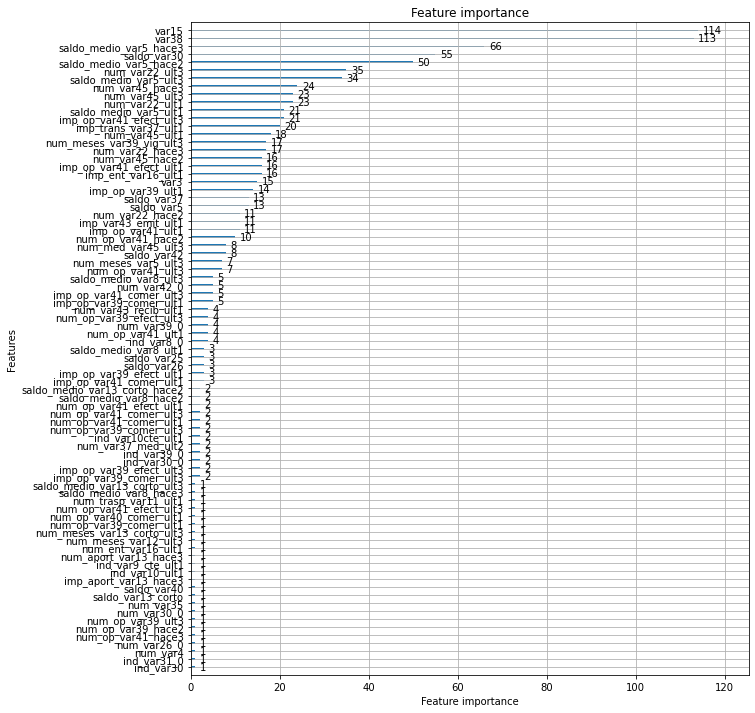

In [25]:
from lightgbm import plot_importance # 시각화
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_clf, ax=ax)
plt.show()

머신러닝?
https://hleecaster.com/ml-svm-concept/

분류(알고리즘의 원리를 이해하고 있어야함)

- DecisionTree(분류모델). 앙상블모델(RF, 부스팅계열)들은 다 DT로함.트리기반
> 이진분류. 데이터의 혼잡도를 줄이는 방향으로. 혼잡도를 나타내는 지수(지니계수),1-ntrophy(정보이득)
> DT 하이퍼파라미터 : max-depth, max-, min-sample-leaf, min-test-split...
> https://injo.tistory.com/15
- RandomForest(투표방식으로 최빈값으로 결정)
> DT와 비슷. 여러개로 해야하므로 n_estimator (트리개수 설정)필요
- LogisticRegression
> 회귀선을 이진으로 하려면(0, 1. 성공,실패) 오즈의 비.
- KNN(K-최근접이웃)
> k값에 의해 정해짐
- SVM(서포트 벡터 머신)
> 서포트 벡터를 잇는 선과 결정경계선과 가장 가까운 점의 거리 : 마진. 마진을 가장 크게 해야함
> 하드마진, 소프트 마진. 과적합 빠지지 않게 해줌.

[부스팅]
- GBM
> 잘못 분류된 것에 대해 가중치 부여. 다시 실수하지 않게 부스팅 시키는 것
> 단점 : 시간이 엄청 오래걸림. 
- XGBoost
> 여전히 시간이 오래걸림
- LightGBM
> 그래서 나온게 LGBM. 균형트리분할, 리프중심 트리분할은 서로 차이가 있음

- early_stopping_round 복습
* 배깅방식(p.211)(rf? dt?)